In [2]:
!pip install fastai -Uqq
!pip install timm -Uqq

In [3]:
from fastai.vision.all import *
import timm
import torch

/home/dnth/anaconda3/envs/fastdupv1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Import the necessary libraries
from fastai.vision.all import *

# Define the paths to the train and validation directories
path = Path('data')

# Load the data using the fastai library
dls = ImageDataLoaders.from_folder(path=path, train='train_set', valid='valid_set', 
                                   batch_tfms=aug_transforms(mult=1.5, size=150, min_scale=0.75),
                                   item_tfms=Resize(224), bs=32)

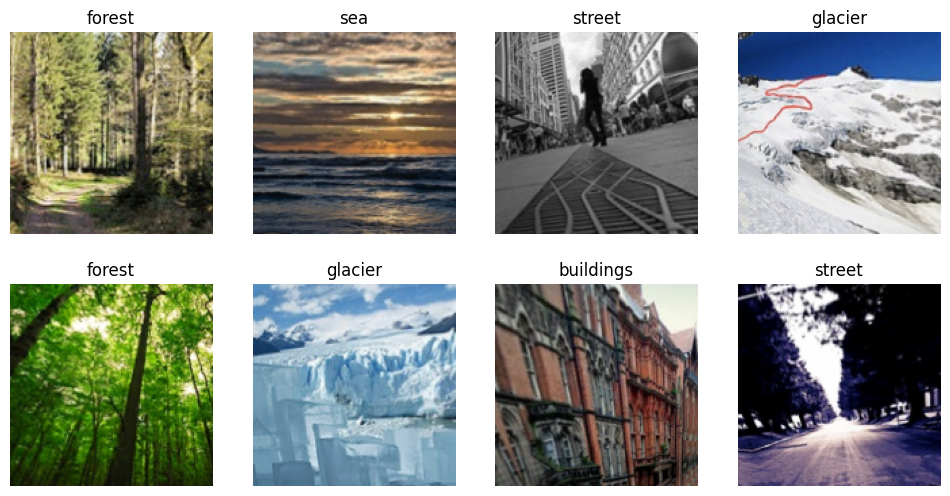

In [5]:
dls.train.show_batch(max_n=8, nrows=2)

In [6]:
learn = vision_learner(dls, 'convnext_tiny_in22k', metrics=accuracy).to_fp16()

SuggestedLRs(valley=0.0012022644514217973)

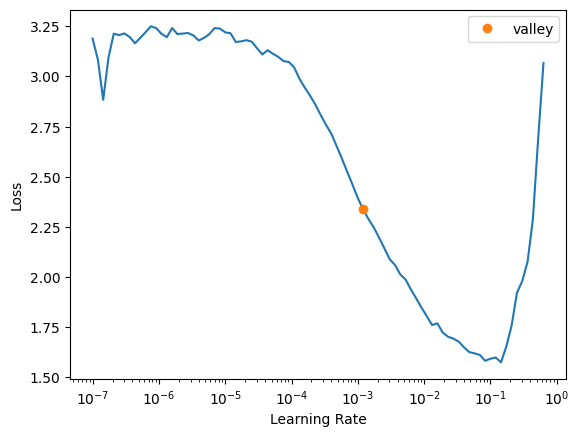

In [7]:
learn.lr_find()

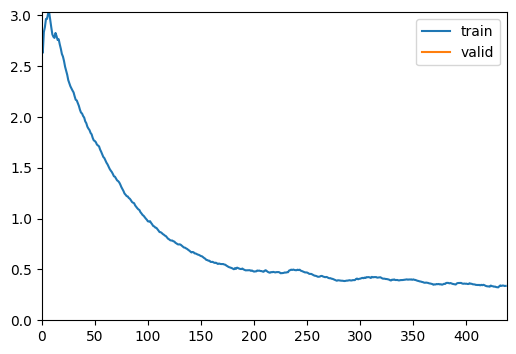

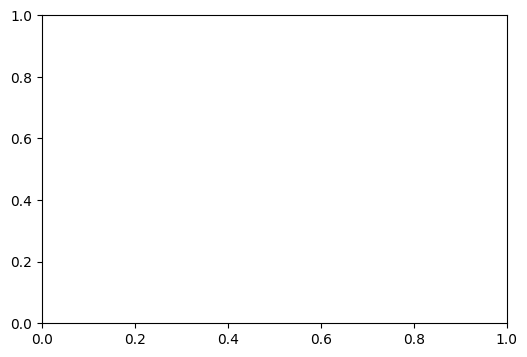

In [8]:
learn.fine_tune(5, base_lr=1e-3, cbs=[ShowGraphCallback()])

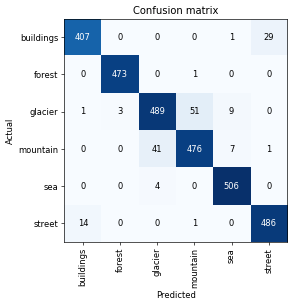

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [10]:
learn.export("./models/learner.pkl")